In [59]:
!pip install langdetect
!pip install emoji==1.7
!python -m spacy download en_core_web_lg
import os
import re
import pandas as pd
import glob
from langdetect import detect
import csv
import sys
import emoji
import spacy
import regex
import re
from google.colab import drive
import string
from collections import Counter
import gensim
from gensim import corpora, models
# Calculate coherence score
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-03 06:37:43.118995: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


The load_dataset function reads one or more CSV files located at the specified path, concatenates them into a single Pandas DataFrame, and adds a new column named "COMPANY" with the name of the company whose tweets are contained in each CSV file. The resulting concatenated DataFrame has five columns: 'USER', 'TWEET', 'TIMESTAMP', 'LINK', and 'COMPANY'.

In [60]:
def load_dataset(path):
    csv_files = glob.glob(os.path.join(path, "*.csv"))
    df_list = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file, header=None)
        df['COMPANY'] = csv_file.split("/")[-1].split('layoffs_scraped_tweets.csv')[0].capitalize()
        df_list.append(df)
    main_df = pd.concat(df_list, axis=0)
    main_df.columns = ['USER', 'TWEET', 'TIMESTAMP', 'LINK', 'COMPANY']
    return main_df

In [61]:
drive.mount('/drive', force_remount=True)
path = '/drive/My Drive/Colab Notebooks/IST 664/Project_Data/Tweets_Data/'
df = load_dataset(path)

Mounted at /drive


The code defines a function detect_language that takes a text argument and uses the detect function from the langdetect library to detect the language of the text. If the language cannot be detected, the function returns "unknown".

The detect_language function is applied to the TWEET column of a Pandas DataFrame df, and the resulting language detection is stored in a new column named LANGUAGE.

Finally, the code filters out all rows where the LANGUAGE column is not 'en' (English) by creating a new DataFrame that contains only rows where the LANGUAGE column is 'en' and dropping the LANGUAGE column. The resulting DataFrame contains only tweets in English.

In [62]:
# function to detect the language of a sentence
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

# apply the detect_language function to the TEXT column and create a new column
df['LANGUAGE'] = df['TWEET'].apply(detect_language)

# remove rows where the LANGUAGE column is not 'en' (English)
df = df[df['LANGUAGE'] == 'en'].drop(columns=['LANGUAGE'])

In [63]:
df.to_csv('final_data.csv', index=False)

In [64]:
df = pd.read_csv('final_data.csv')

In [65]:
df.head()

,USER,TWEET,TIMESTAMP,LINK,COMPANY
0,franchisefun,What If Franchise Business Ownership Is Not Yo...,2023-04-13 12:40:17+00:00,https://twitter.com/franchisefun/status/164649...,Amazon
1,franchisefun,STOP! You Want To Start A Business With No Pri...,2023-04-12 14:38:27+00:00,https://twitter.com/franchisefun/status/164616...,Amazon
2,franchisefun,We Don't Know What We Don't Know!\n\nHow Can Y...,2023-04-11 14:23:11+00:00,https://twitter.com/franchisefun/status/164579...,Amazon
3,JaanoJunction,"From Google to Amazon, tech giants offer 1-yea...",2023-04-11 09:23:58+00:00,https://twitter.com/JaanoJunction/status/16457...,Amazon
4,PrateekGaurav23,#layoffs2023 #amazonlayoffs #F1Visa\n\nMy rece...,2023-04-10 19:55:34+00:00,https://twitter.com/PrateekGaurav23/status/164...,Amazon


The code defines two functions, replace_emojis and data_cleaning.

The replace_emojis function takes a text argument and uses the emoji library to replace emojis in the text with their descriptions. It splits the text into individual words and replaces any emojis found in the words with their corresponding descriptions. The resulting text is returned.

The data_cleaning function takes a Pandas DataFrame main_df as an argument and performs several data cleaning tasks. It drops duplicates from the DataFrame, removes mentions and links from the TWEET column using regular expressions, extracts words with hashtags and places them in a new HASHTAGS column, and removes words with hashtags from the TWEET column. Finally, it applies the replace_emojis function to the TWEET column to replace emojis with their descriptions. The resulting cleaned DataFrame is returned.

In [66]:
# Define a function to replace emojis with their descriptions
def replace_emojis(text):
    for emoji_char in emoji.emojize(text).split():
        description = emoji.demojize(emoji_char).replace(":","")
        text = text.replace(emoji_char, description)
    return text

def data_cleaning(main_df):
    
    
    # dropping duplicates from the dataframe
    main_df.drop_duplicates(inplace = True) 

    # define the regular expression pattern to match @ links
    at_pattern = re.compile(r'@\S+')
    # remove http links from the TWEET column
    
    main_df['TWEET'].replace(at_pattern, '', regex=True, inplace = True)

    # define the regular expression pattern to match http links
    http_pattern = re.compile(r'http\S+')
    # remove http links from the TWEET column
    main_df['TWEET'].replace(http_pattern, '', regex=True, inplace = True)

    # define the regular expression pattern to match words with hashtags
    hashtag_word_pattern = re.compile(r'(\#\w+)')
    # extract words with hashtags from the TWEET column and place them in a new column
    main_df['HASHTAGS'] = main_df['TWEET'].str.extractall(hashtag_word_pattern)[0].groupby(level=0).apply(list)

    # remove words with hashtags from the TWEET column
    main_df['TWEET'].replace(hashtag_word_pattern, '', regex=True, inplace = True)

    # Replace emojis with their descriptions
    main_df['TWEET'] = main_df['TWEET'].apply(lambda x: " ".join(replace_emojis(sentence) for sentence in x.split()))
    
    return main_df


In [67]:
df = data_cleaning(df)
df.shape

(76147, 6)

In [68]:
df.dropna(subset=['TWEET'], inplace=True)
df.shape

(76147, 6)

In [69]:
df.to_csv('cleaned_data.csv', index=False)

In [70]:
df = pd.read_csv('cleaned_data.csv')

The code defines a function preprocess_data that performs text preprocessing tasks on a Pandas DataFrame df. The function takes several arguments:

remove_stop is a boolean flag that determines whether to remove stop words from the text.
lemmetize is a boolean flag that determines whether to perform lemmatization on the text.
input_col_name is the name of the input column containing the text to be preprocessed.
output_col_name is the name of the output column to store the preprocessed text.
The function first initializes a tokenizer from the nltk library that is specifically designed for tweets. It applies this tokenizer to the text in the input column, converts the resulting tokens to lowercase, and stores the output in the output column.

If remove_stop is set to True, the function removes stop words from the text using the stopwords corpus from nltk.

The function then filters out any tokens that are less than two characters long or contain non-alphanumeric characters.

Finally, if lemmetize is set to True, the function performs lemmatization on the text. Otherwise, it skips this step.

The resulting preprocessed text is stored in the output column as a list of unique tokens.

In [71]:
#  Preprocessing
import nltk

def preprocess_data(df, remove_stop, lemmetize,input_col_name, output_col_name):
    
    tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=False, reduce_len=True)
    df[output_col_name] = df[input_col_name].apply(lambda x: tokenizer.tokenize(x.lower()) if isinstance(x,str) else [])
    
    if remove_stop:
        stop_words = set(nltk.corpus.stopwords.words('english'))
        df[output_col_name] = df[output_col_name].apply(lambda x: [w for w in x if w not in stop_words])
    
    df[output_col_name] = df[output_col_name].apply(lambda tokens: [token for token in tokens if len(token) > 1 and token.isalnum()])
    
    # code for lemmetization
    if lemmetize:
        pass
    
    df[output_col_name] = df[output_col_name].apply(lambda tokens: list(set(tokens)))

In [72]:
import nltk
nltk.download('stopwords')
preprocess_data(df,True,True,"TWEET","preprocessed_TWEETS")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
df["preprocessed_TWEETS"].head()

0    [success, rather, business, another, key, conn...
1    [stop, prior, experience, mad, business, want,...
2    [knowing, without, search, franchise, help, kn...
3    [amazon, tech, encourage, voluntarily, resign,...
4    [experience, new, layoffs, unexpected, recent,...
Name: preprocessed_TWEETS, dtype: object

The code defines a dictionary (id2word) for the preprocessed tweets in the DataFrame, using the corpora.Dictionary() function from the Gensim library. It then filters the dictionary to keep only tokens that appear in at least 2 documents and are present in less than 99% of the documents (filter_extremes() method). Finally, the code creates a corpus for the preprocessed tweets using the doc2bow() method from the dictionary, which converts the preprocessed tweet into a bag-of-words representation.

In [74]:
id2word = corpora.Dictionary(df["preprocessed_TWEETS"])
id2word.filter_extremes(no_below=2, no_above=.99)
corpus = [id2word.doc2bow(d) for d in df["preprocessed_TWEETS"]]

The code defines a function named LDA that takes in several parameters, including num_topics, workers, passes, num_of_words, id2word_dict, and corpus. The function then creates an LDA (Latent Dirichlet Allocation) model using the ldamulticore.LdaMulticore() function from the Gensim library. The LDA model is trained on the input corpus and the id2word_dict dictionary, with num_topics, workers, and passes as the number of topics to be inferred, the number of parallel workers to be used for training, and the number of times the corpus is passed through the LDA model. Finally, the function returns the LDA model and the top 10 words for each topic obtained using the print_topics() method.

In [75]:
# LDA model analysis
def LDA(num_topics, workers,passes, num_of_words, id2word_dict, corpus):
    np.random.seed(42)
    lda = models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word_dict,workers=workers, passes = passes)
    return lda,lda.print_topics(num_words=10)

The code below trains an LDA model using the specified parameters, prints the top 10 words for each topic, and calculates the coherence score of the model using the preprocessed tweets and the dictionary created using id2word.

In [76]:
lda,topics = LDA(5,7,20,10,id2word,corpus) 
# Parameters : dataframe column, number of topics, workers for parallelization, passes (epochs ), filter_extremes, number of words per topic 

for topic_id, topic in topics:
    print('Topic {}: {}'.format(topic_id, topic))
print ("\n\n")

# Caluculate coherance score
coherence_model_lda = CoherenceModel(model=lda, texts=df["preprocessed_TWEETS"], dictionary=id2word, coherence='c_v')
print('Coherence Score:', coherence_model_lda.get_coherence())

Topic 0: 0.021*"layoffs" + 0.019*"employees" + 0.016*"vacancies" + 0.013*"twitter" + 0.009*"tech" + 0.008*"india" + 0.008*"jobs" + 0.007*"workers" + 0.007*"robot" + 0.007*"ibm"
Topic 1: 0.015*"twitter" + 0.013*"people" + 0.008*"like" + 0.007*"get" + 0.007*"work" + 0.006*"one" + 0.006*"time" + 0.006*"know" + 0.005*"employees" + 0.005*"laid"
Topic 2: 0.019*"job" + 0.015*"unemployment" + 0.014*"rate" + 0.009*"help" + 0.008*"jobs" + 0.008*"get" + 0.008*"career" + 0.008*"us" + 0.008*"2023" + 0.008*"new"
Topic 3: 0.053*"apply" + 0.046*"job" + 0.045*"resume" + 0.044*"post" + 0.043*"online" + 0.041*"rocket" + 0.040*"star" + 0.027*"pakistan" + 0.011*"states" + 0.011*"united"
Topic 4: 0.048*"apply" + 0.041*"click" + 0.028*"hiring" + 0.027*"job" + 0.023*"link" + 0.015*"location" + 0.011*"jobs" + 0.010*"lagos" + 0.009*"visit" + 0.009*"manager"



Coherence Score: 0.4590255155613033


The following code defines a function HDP which takes a dataframe column, number of topics, and number of words as input parameters. The function then vectorizes the data using CountVectorizer, creates a gensim dictionary object and converts the document-term matrix into a gensim corpus object. Finally, it trains a Hierarchical Dirichlet Process (HDP) topic model using the corpus and dictionary objects, and returns the trained model, topics, and corpus.

In [77]:
from gensim.models import HdpModel
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import CountVectorizer

def HDP(df_column,num_topics,num_words):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

    # Vectorize the data
    X = vectorizer.fit_transform([' '.join(tokens) for tokens in df_column])

    # Create a Gensim Dictionary object
    gensim_dict = Dictionary([vectorizer.get_feature_names_out()])

    # Convert the document-term matrix into a Gensim Corpus object
    corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

    # Train the HDP model
    hdp = HdpModel(corpus=corpus, id2word=gensim_dict)
    
    return hdp, hdp.print_topics(num_topics=num_topics, num_words=num_words),corpus

The code performs topic modeling using Hierarchical Dirichlet Process (HDP) algorithm. It defines a function HDP that takes a dataframe column, number of topics and number of words to be displayed per topic as input, and returns the trained HDP model, the topics and the corpus. The code then calls the HDP function, prints the topics and calculates the coherence score using the CoherenceModel function. Finally, it prints the coherence score.

In [78]:
hdp,topics,corpus = HDP(df["preprocessed_TWEETS"],5,10)

for topic in topics:
    print(topic)

# Caluculate coherance score
coherence_model_hdp = CoherenceModel(model=hdp, texts=df["preprocessed_TWEETS"], dictionary=id2word, coherence='c_v')
print ("\n\n")
print('Coherence Score:', coherence_model_hdp.get_coherence())

(0, '0.017*job + 0.011*apply + 0.010*twitter + 0.007*jobs + 0.007*employees + 0.007*post + 0.006*resume + 0.006*people + 0.006*online + 0.006*rocket')
(1, '0.009*apply + 0.007*click + 0.006*job + 0.004*location + 0.004*jobs + 0.003*hiring + 0.003*twitter + 0.003*lagos + 0.002*new + 0.002*people')
(2, '0.005*helen + 0.005*contact + 0.005*bchs + 0.005*salt + 0.005*pr + 0.004*hybrid + 0.004*job + 0.003*b2b + 0.003*twitter + 0.003*clients')
(3, '0.005*job + 0.004*twitter + 0.004*apply + 0.002*click + 0.002*people + 0.002*employees + 0.002*help + 0.002*like + 0.002*jobs + 0.002*new')
(4, '0.004*job + 0.004*twitter + 0.003*apply + 0.003*people + 0.002*employees + 0.002*jobs + 0.002*click + 0.002*hiring + 0.002*elon + 0.001*new')



Coherence Score: 0.6464872428910231


The code defines a function NMF_ that takes a dataframe column and a number of components as input. It creates a CountVectorizer, fits and transforms the documents, and creates an NMF model with the specified number of components. Finally, it fits the model to the count matrix and returns the model and vectorizer objects.

In [79]:
# NMF analysis 
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer;
from sklearn.decomposition import NMF
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import normalize

def NMF_(df_column, components):
    # Create a count vectorizer
    vectorizer = CountVectorizer()
    # Fit and transform the documents
    X = vectorizer.fit_transform([' '.join(tokens) for tokens in df_column])
    # Create an NMF model
    model = NMF(n_components=5)
    # Fit the model to the count matrix
    W = model.fit_transform(X)

    return model, vectorizer

The code defines a function NMF_ that takes a dataframe column and the number of components as input. It creates a count vectorizer, fits and transforms the documents, creates an NMF model, and fits the model to the count matrix.

Then, the code uses the NMF model and the vectorizer to print the top terms for each topic, and also calculates the coherence score using the top words for each topic, the preprocessed tweets and the dictionary. The coherence score is printed at the end.

In [80]:
nmf, vectorizer=  NMF_(df["preprocessed_TWEETS"],10)
# Print the top terms for each topic
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
# get the top words for each topic
top_words_per_topic = []
# create a dictionary mapping each term to a unique integer ID
dictionary = corpora.Dictionary(df["preprocessed_TWEETS"])
for topic_idx, topic in enumerate(nmf.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    top_words = [dictionary[i] for i in nmf.components_[topic_idx].argsort()[:-5 - 1:-1]]
    top_words_per_topic.append(top_words)

print ("\n\n")

# create a coherence model
coherence_model_nmf = gensim.models.CoherenceModel(topics=top_words_per_topic, texts=df["preprocessed_TWEETS"], dictionary=dictionary, coherence='c_v')

# calculate the coherence score
print(coherence_model_nmf.get_coherence())

Topic #0:
post resume online apply rocket star pakistan lahore karachi islamabad
Topic #1:
twitter employees elon musk layoffs fired laid company like staff
Topic #2:
apply click hiring link location lagos vacancies jobs visit manager
Topic #3:
job link vacancies search find details help get looking experience
Topic #4:
people jobs unemployment rate get us new work like time



0.07306254360062212


The below code defines a function evaluate_bar_graph that takes a list of coherence values and a list of corresponding model names and plots a bar graph of the coherence values for each model. Then it calculates the coherence values for three topic modeling models - NMF, LDA, and HDP - using previously defined coherence models, and calls evaluate_bar_graph with these values and model names to plot the coherence values for comparison.

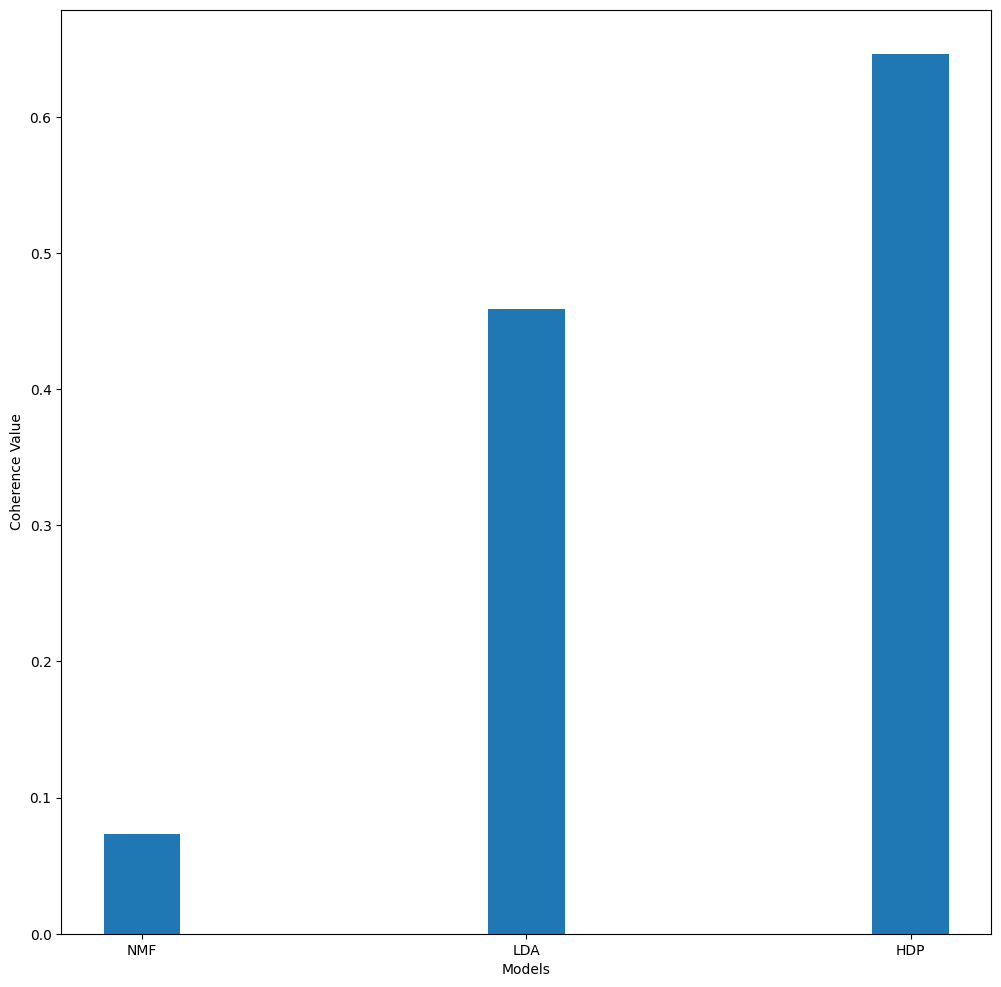

In [81]:
import matplotlib.pyplot as plt

def evaluate_bar_graph(coherences, indices):
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.figure(figsize=(12,12))
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

coherence_nmf = coherence_model_nmf.get_coherence()
coherence_lda = coherence_model_lda.get_coherence()
coherence_hdp = coherence_model_hdp.get_coherence()
evaluate_bar_graph([coherence_nmf, coherence_lda, coherence_hdp], ['NMF', 'LDA', 'HDP'])